In [1]:
# These packages are not included in the MomentumED package. 
# Use the following line to add them:
# using Pkg; Pkg.add("CairoMakie"); Pkg.add("QuadGK"); Pkg.add("ClassicalOrthogonalPolynomials")

# Import the momentum-conserved exact diagonalization package
using MomentumED
include("../Landau level triangular.jl")
using .LLT

using CairoMakie # for plotting
CairoMakie.activate!()

# Plot the energy spectrum
function plot_ed_spectrum(subtitle=nothing)
    fig = Figure();
    ax = Axis(fig[1, 1];
        xlabel = "$(Gk[2])k1+k2",
        ylabel = "Energy per unit cell (W₀ = e²/ϵl)"
    )
    ax_top = Axis(fig[1, 1];
        xlabel = "momentum block number",
        xaxisposition = :top
    )
    top_ticks = ([], [])
    hidespines!(ax_top)
    hidexdecorations!(ax_top; label = false, ticklabels = false)
    hideydecorations!(ax_top)
    linkxaxes!(ax, ax_top)

    # Plot energy levels for each momentum block
    for i in 1:length(subspaces)
        x = Gk[2] * ss_k1[i] + ss_k2[i]
        push!(top_ticks[1], x)
        push!(top_ticks[2], string(i))
        for e in energies[i]
            scatter!(ax, x, e/Nk/LLT.W0, color = :blue, marker=:hline)
        end
    end
    ax_top.xticks = top_ticks
    if subtitle isa String
        ax_top.subtitle = subtitle
    end
    display(fig)
end

plot_ed_spectrum (generic function with 2 methods)

In [ ]:
# Define k-mesh for bilayer system (4×3 mesh, Nk=12) in triangular lattice
k_list = [0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2]
Nk = 12
Gk = (4, 3)  # Grid dimensions


# Number of layers (components) for bilayer system
Nc_conserve = 2

2

In [3]:
# Set up one-body Hamiltonian matrix for inter-layer tunneling
ΔE = 0.0 * LLT.W0                # Energy difference between the two layers

# H_onebody[c1, c2, cc, k] : no hopping from component c2 to c1
# For bilayer system: Nc_hopping=1, Nc_conserve=2, No tunneling
H_onebody_bilayer_no_tunneling = zeros(ComplexF64, 1, 1, Nc_conserve, Nk)
for k_idx in 1:Nk
    H_onebody_bilayer_no_tunneling[1, 1, 1, k_idx] = 0.5ΔE
    H_onebody_bilayer_no_tunneling[1, 1, 2, k_idx] = -0.5ΔE
end

# Set up component parameters: (layer, level, Chern number, pseudospin)
sys_int = LandauInteraction(
    (1, 0, 1, 0),
    (2, 0, 1, 0)
);

In [12]:
# Interaction parameters

# Coulomb
sys_int.D_l = 10.0                  # Screening length D/l
sys_int.d_l = 0.5                  # Inter-layer distance d/l
# compute the pseudo-potential components
intra_PP = LLT.pseudo_potential_decomposition.(0:4; same_layer = true,  D_l = sys_int.D_l, d_l = sys_int.d_l)
inter_PP = LLT.pseudo_potential_decomposition.(0:4; same_layer = false, D_l = sys_int.D_l, d_l = sys_int.d_l)
@show intra_PP
@show inter_PP

# Haldane pseudo-potential
# sys_int.V_intra = [0.0; 0.8; 0.0; 0.4]          # Intralayer Haldane pseudo-potential in unit of W0
# sys_int.V_inter = [1.0; 0.7; 0.5; 0.4]          # Interlayer Haldane pseudo-potential in unit of W0

# or use Coulomb interaction with a cutoff in m
sys_int.V_intra = copy(intra_PP)
sys_int.V_inter = copy(inter_PP)

# choose a linear mixing between Haldane and Coulomb interaction
sys_int.mix = 1                  # mix * Haldane + (1-mix) * Coulomb

# Create parameter structure for bilayer system
para_conserve = EDPara(
    k_list = k_list, 
    Gk = Gk, 
    Nc_hopping = 1,
    Nc_conserve = Nc_conserve,
    H_onebody = H_onebody_bilayer_no_tunneling,
    V_int = sys_int,
    FF_inf_angle = LLT.Landau_ff_inf(sys_int),
);

intra_PP = [1.634583819831362, 0.7492338495371395, 0.5285404117300112, 0.4186120084649848, 0.35021248081085243]
inter_PP = [1.227680253714756, 0.7105139963611995, 0.5157214926633534, 0.41202552162139605, 0.34609651899890626]


In [35]:
# number of electrons in each layer
Ne1 = 6
Ne2 = 6

6

In [36]:
NG = 2
index_shift = NG .* Gk .+ 1
densities = MBOperator[density_operator(q1, q2, lf, li; 
        para = para_conserve, form_factor = true)
    for q1 in -NG*Gk[1]:NG*Gk[1], q2 in -NG*Gk[2]:NG*Gk[2], lf = 1:2, li=1:2
];
function structure_factor_expectation(myvec)
    structure_factor = similar(densities, ComplexF64)
    for q1 in -NG*Gk[1]:NG*Gk[1], q2 in -NG*Gk[2]:NG*Gk[2]
        for lf = 1:2, li = 1:2
            structure_factor[index_shift[1]+q1, index_shift[2]+q2, lf, li] = 
                ED_bracket_threaded(myvec, 
                    densities[index_shift[1]-q1, index_shift[2]-q2, li, lf], 
                    densities[index_shift[1]+q1, index_shift[2]+q2, lf, li], myvec
                )
            if mod(q1, Gk[1]) == 0 && mod(q2, Gk[2])== 0 && lf==li
                structure_factor[index_shift[1]+q1, index_shift[2]+q2, lf, li] -= 
                    ED_bracket_threaded(myvec, densities[index_shift[1]-q1, index_shift[2]-q2, li, lf], myvec) * 
                    ED_bracket_threaded(myvec, densities[index_shift[1]+q1, index_shift[2]+q2, lf, li], myvec)
            end
        end
    end
    structure_factor ./= Nk
end

structure_factor_expectation (generic function with 1 method)

In [37]:
# Create momentum blocks (Hilbert subspace) for bilayer system
subspaces, ss_k1, ss_k2 = 
    ED_momentum_subspaces(para_conserve, (Ne1, Ne2));
display(length.(subspaces))

# Generate Scatter lists for efficient Hamiltonian construction
scat_list1_conserve = ED_sortedScatterList_onebody(para_conserve);
scat_list2_conserve = ED_sortedScatterList_twobody(para_conserve);

12-element Vector{Int64}:
 71188
 71178
 71178
 71120
 71112
 71112
 71188
 71178
 71178
 71120
 71112
 71112

In [38]:
Neigen = 10  # Number of eigenvalues to compute per subspace
energies = Vector{Vector{Float64}}(undef, length(subspaces));
vectors = Vector{Vector{<:MBS64Vector}}(undef, length(subspaces));
for i in eachindex(subspaces)
    println("Processing block #$i with size $(length(subspaces[i])), momentum $(ss_k1[i]), $(ss_k2[i])")
    energies[i], vectors[i] = EDsolve(subspaces[i], scat_list2_conserve, scat_list1_conserve;
        N=Neigen, showtime=true, ishermitian=true
    )
end

Processing block #1 with size 71188, momentum 0, 0
  1.275023 seconds (92.05 k allocations: 1.916 GiB, 33.08% gc time)
  8.164428 seconds (35.82 k allocations: 1.175 GiB, 3.06% gc time)
Processing block #2 with size 71178, momentum 0, 1
  1.183625 seconds (71.98 k allocations: 1.914 GiB, 25.54% gc time)
  5.652805 seconds (30.68 k allocations: 809.433 MiB, 5.79% gc time)
Processing block #3 with size 71178, momentum 0, 2
  1.165061 seconds (71.98 k allocations: 1.914 GiB, 26.12% gc time)
  5.604193 seconds (30.68 k allocations: 809.432 MiB, 3.40% gc time)
Processing block #4 with size 71120, momentum 1, 0
  1.197497 seconds (71.92 k allocations: 1.913 GiB, 26.66% gc time)
  7.447094 seconds (32.95 k allocations: 1.108 GiB, 4.25% gc time)
Processing block #5 with size 71112, momentum 1, 1
  1.219167 seconds (71.91 k allocations: 1.912 GiB, 22.43% gc time)
  6.086221 seconds (29.07 k allocations: 904.146 MiB, 3.79% gc time)
Processing block #6 with size 71112, momentum 1, 2
  1.163271 se

In [43]:
# check energies explicitly to see degeneracy.

sn = 7 # the subspace number to inspect
println("total momentum: ", ss_k1[sn], "  ", ss_k2[sn])
energies[sn]/Nk/LLT.W0

total momentum: 2  0


10-element Vector{Float64}:
 1.1428967312201002
 1.1835726205777395
 1.1846599907125788
 1.1846599907125792
 1.188558443958659
 1.1888255177129794
 1.1888255177129803
 1.1940061188160365
 1.194006118816039
 1.1948722970689458

Plot the spectrums for different layer fillings with total filling 1, and calculate their structure factors

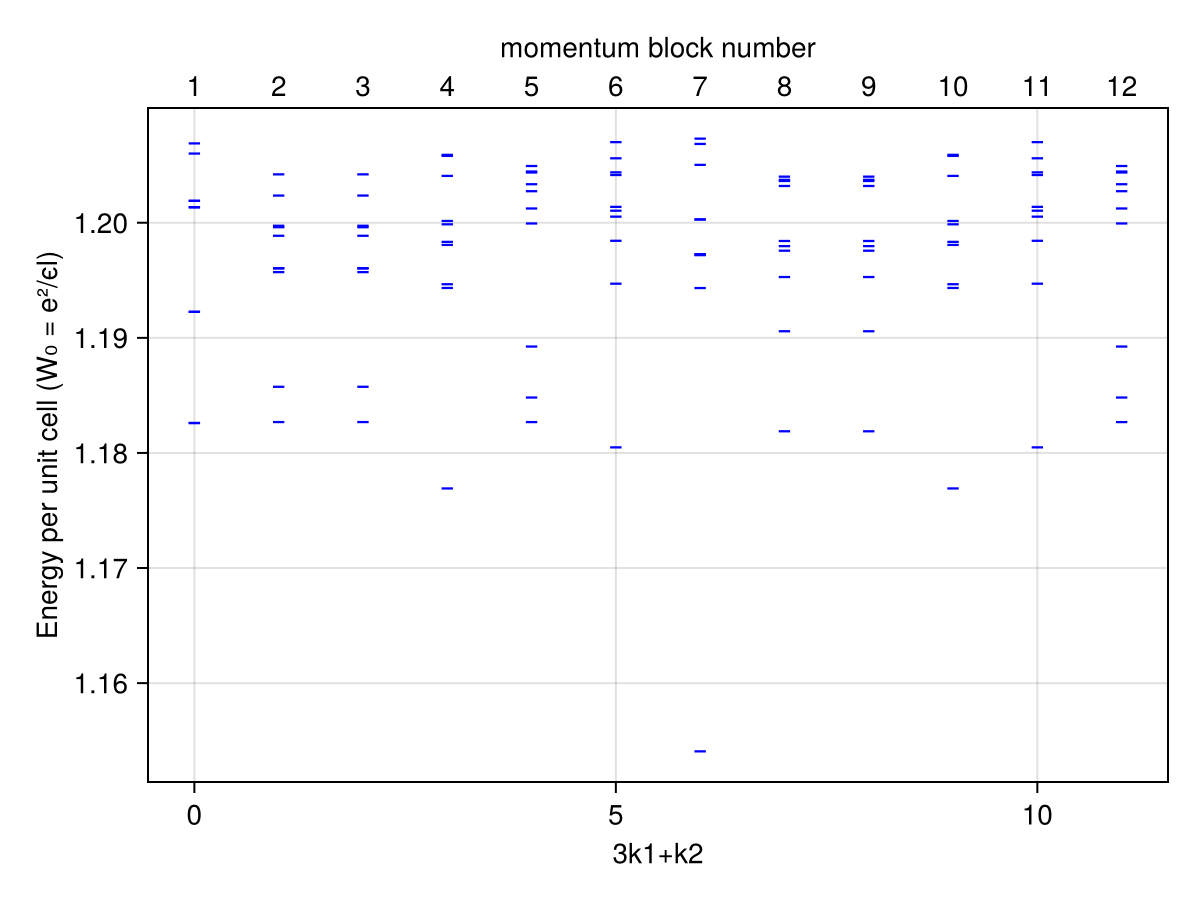

((energies[7])[1] / Nk) / LLT.W0 = 1.1540695984448004
  0.188552 seconds (82.78 k allocations: 5.333 MiB, 17.88% compilation time)
maximum(abs.(imag.(str_fac210))) = 1.7640898008226536e-18
extrema(real.(str_fac210)) = (-8.289665250534503e-15, 2.497947528161259)
str_fac210[index_shift..., 1, 2] = 2.497947528161259 + 0.0im
str_fac210[index_shift..., 2, 1] = 1.831280861494592 + 0.0im


1.831280861494592 + 0.0im

In [29]:
plot_ed_spectrum() # 2, 10
@show energies[7][1]/Nk/LLT.W0
myvec210 = vectors[7][1]
@time str_fac210 = structure_factor_expectation(myvec210);
@show maximum(abs.(imag.(str_fac210)))
@show extrema(real.(str_fac210))
@show str_fac210[index_shift..., 1,2]
@show str_fac210[index_shift..., 2,1]

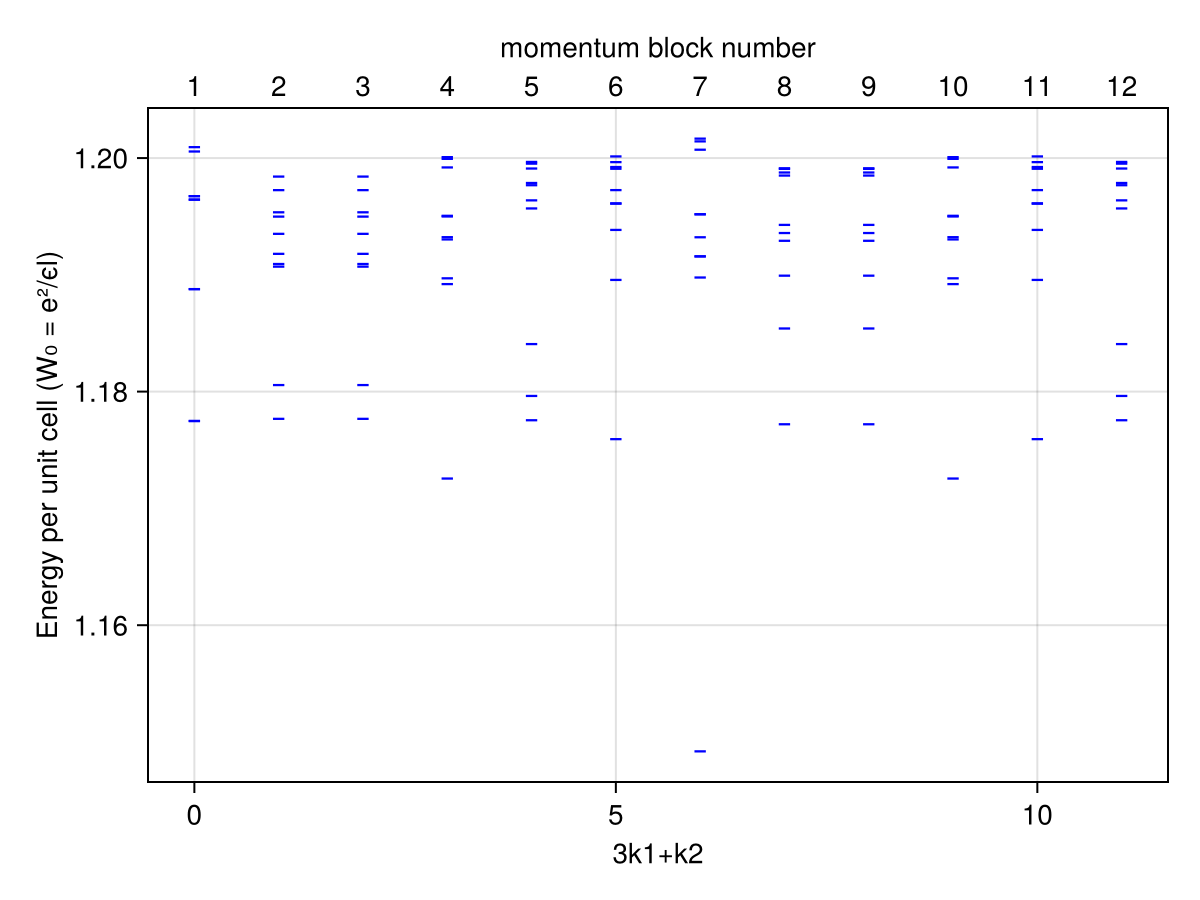

((energies[7])[1] / Nk) / LLT.W0 = 1.1491982152167461
  1.045244 seconds (82.78 k allocations: 5.333 MiB, 3.33% compilation time)
maximum(abs.(imag.(str_fac39))) = 2.0718778820234874e-18
extrema(real.(str_fac39)) = (-3.789561257387201e-14, 2.9950608842264432)
str_fac39[index_shift..., 1, 2] = 2.9950608842264432 + 0.0im
str_fac39[index_shift..., 2, 1] = 2.4950608842264406 + 0.0im


2.4950608842264406 + 0.0im

In [24]:
plot_ed_spectrum() # 3, 9
@show energies[7][1]/Nk/LLT.W0
myvec39 = vectors[7][1]
@time str_fac39 = structure_factor_expectation(myvec39);
@show maximum(abs.(imag.(str_fac39)))
@show extrema(real.(str_fac39))
@show str_fac39[index_shift..., 1,2]
@show str_fac39[index_shift..., 2,1]

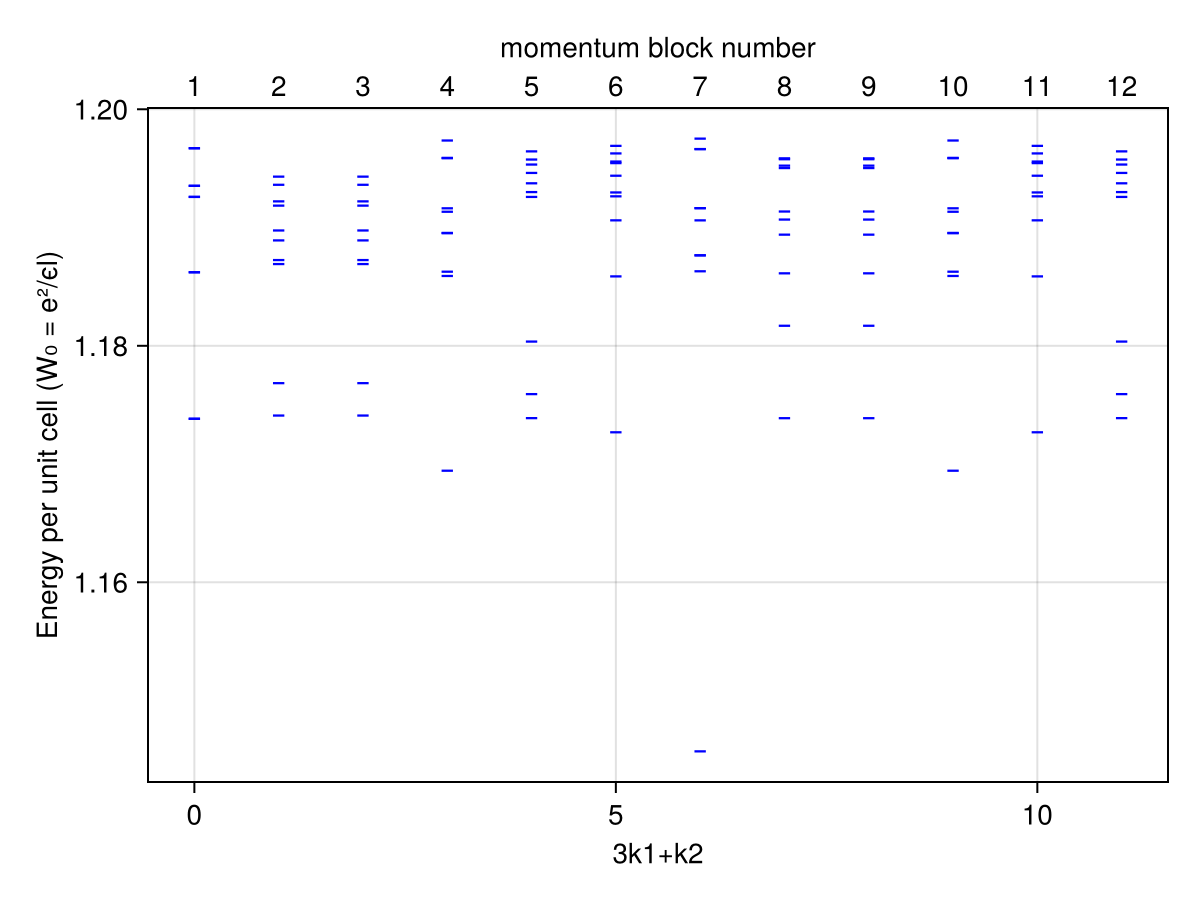

((energies[7])[1] / Nk) / LLT.W0 = 1.1457027106097608
  4.888278 seconds (82.77 k allocations: 5.333 MiB, 0.74% compilation time)
maximum(abs.(imag.(str_fac48))) = 1.516674183586309e-18
extrema(real.(str_fac48)) = (-1.0362081563168128e-15, 3.3256357763931548)
str_fac48[index_shift..., 1, 2] = 3.3256357763931548 + 0.0im
str_fac48[index_shift..., 2, 1] = 2.9923024430598275 + 0.0im


2.9923024430598275 + 0.0im

In [19]:
plot_ed_spectrum() # 4, 8
@show energies[7][1]/Nk/LLT.W0
myvec48 = vectors[7][1]
@time str_fac48 = structure_factor_expectation(myvec48);
@show maximum(abs.(imag.(str_fac48)))
@show extrema(real.(str_fac48))
@show str_fac48[index_shift..., 1,2]
@show str_fac48[index_shift..., 2,1]

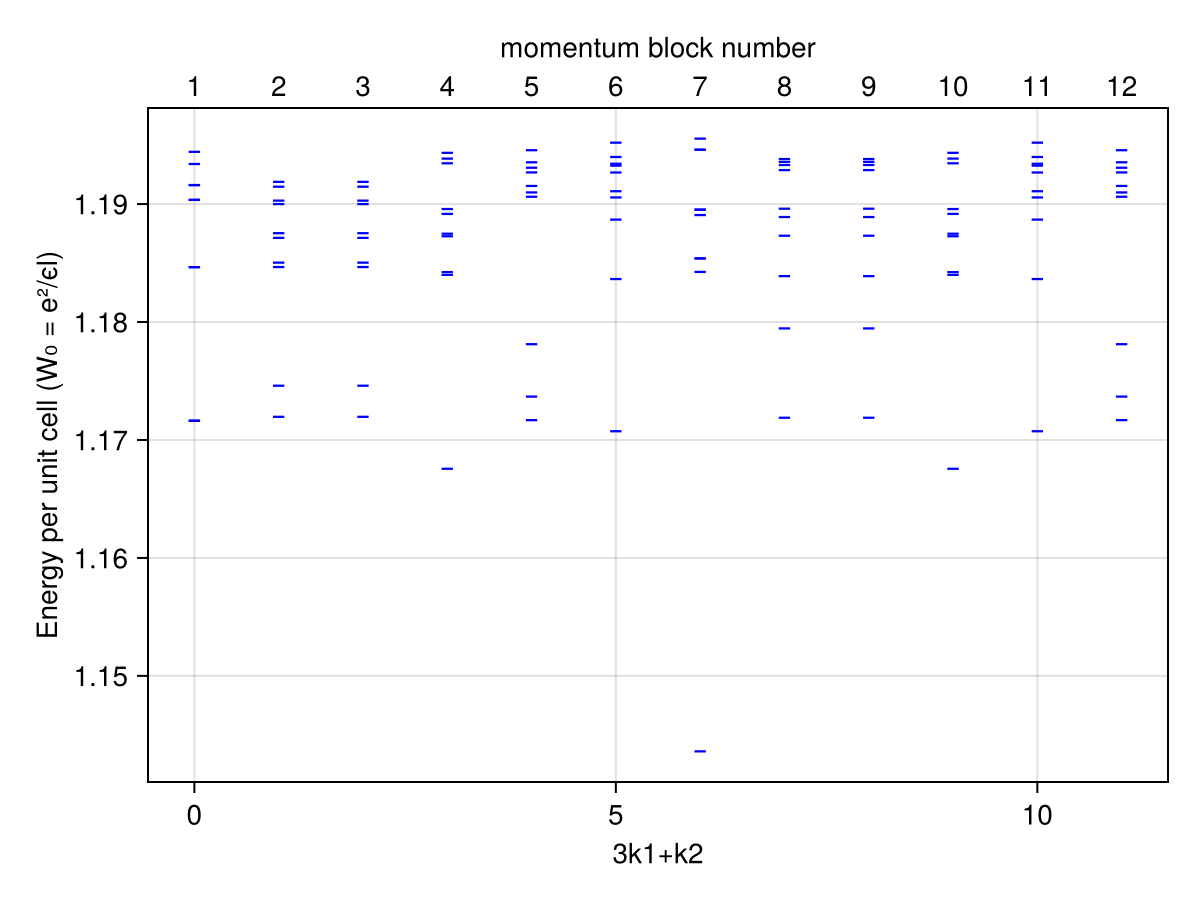

((energies[7])[1] / Nk) / LLT.W0 = 1.1435990230510613
 13.000177 seconds (82.78 k allocations: 5.336 MiB, 0.30% compilation time)
maximum(abs.(imag.(str_fac57))) = 1.7331814778956207e-18
extrema(real.(str_fac57)) = (-4.263256414560601e-14, 3.4903717503870655)
str_fac57[index_shift..., 1, 2] = 3.4903717503870655 + 0.0im
str_fac57[index_shift..., 2, 1] = 3.323705083720395 + 0.0im


3.323705083720395 + 0.0im

In [34]:
plot_ed_spectrum() # 5, 7
@show energies[7][1]/Nk/LLT.W0
myvec57 = vectors[7][1]
@time str_fac57 = structure_factor_expectation(myvec57);
@show maximum(abs.(imag.(str_fac57)))
@show extrema(real.(str_fac57))
@show str_fac57[index_shift..., 1,2]
@show str_fac57[index_shift..., 2,1]

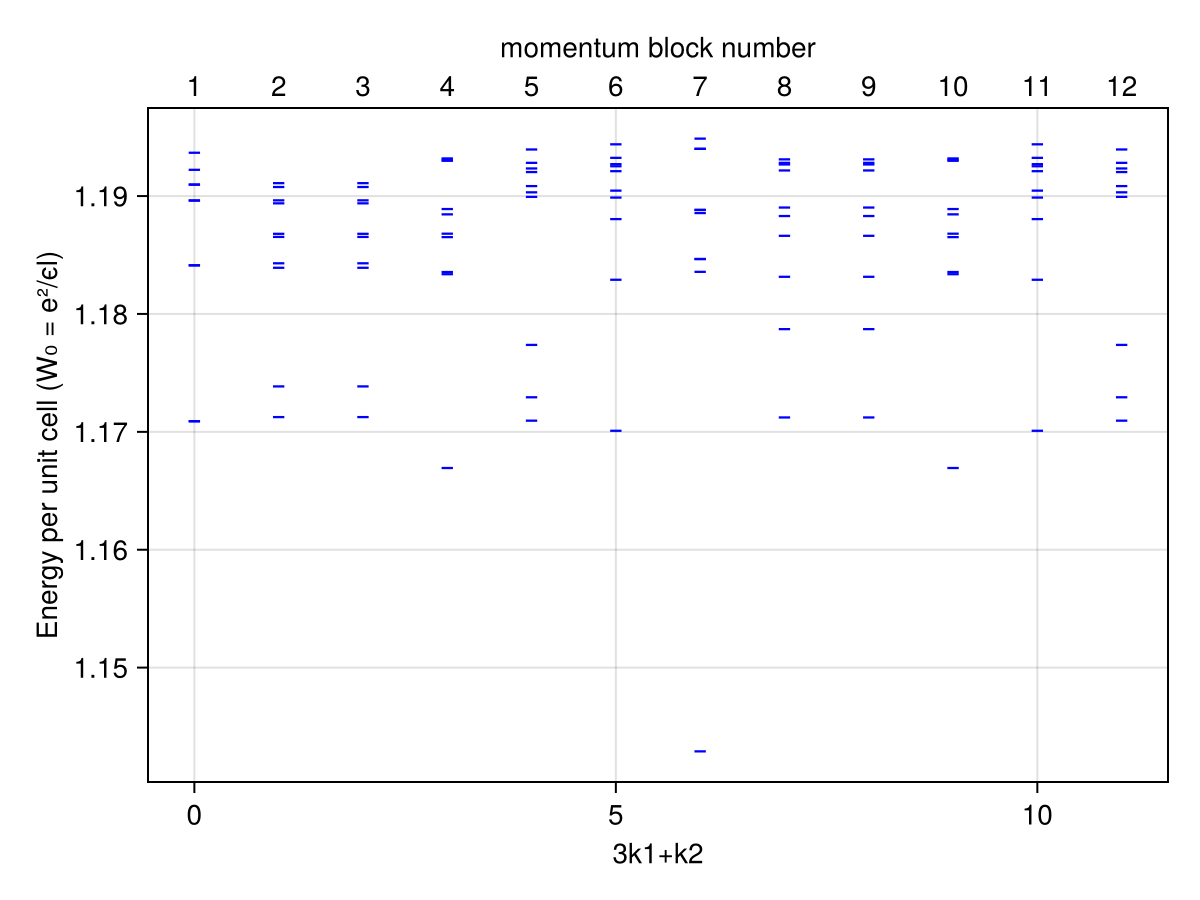

((energies[7])[1] / Nk) / LLT.W0 = 1.1428967312201002
 17.188854 seconds (82.80 k allocations: 5.337 MiB, 0.20% compilation time)
maximum(abs.(imag.(str_fac66))) = 1.1683545305575636e-18
extrema(real.(str_fac66)) = (2.8911227845149823e-20, 3.4896829114393615)
str_fac66[index_shift..., 1, 2] = 3.489682911439361 + 3.3658065289429835e-29im
str_fac66[index_shift..., 2, 1] = 3.4896829114393615 - 1.6829032644714918e-29im


3.4896829114393615 - 1.6829032644714918e-29im

In [39]:
plot_ed_spectrum() # 6, 6
@show energies[7][1]/Nk/LLT.W0
myvec66 = vectors[7][1]
@time str_fac66 = structure_factor_expectation(myvec66);
@show maximum(abs.(imag.(str_fac66)))
@show extrema(real.(str_fac66))
@show str_fac66[index_shift..., 1,2]
@show str_fac66[index_shift..., 2,1]

Plot structure factors (when layer indices are different, it's equivalent to exciton density)

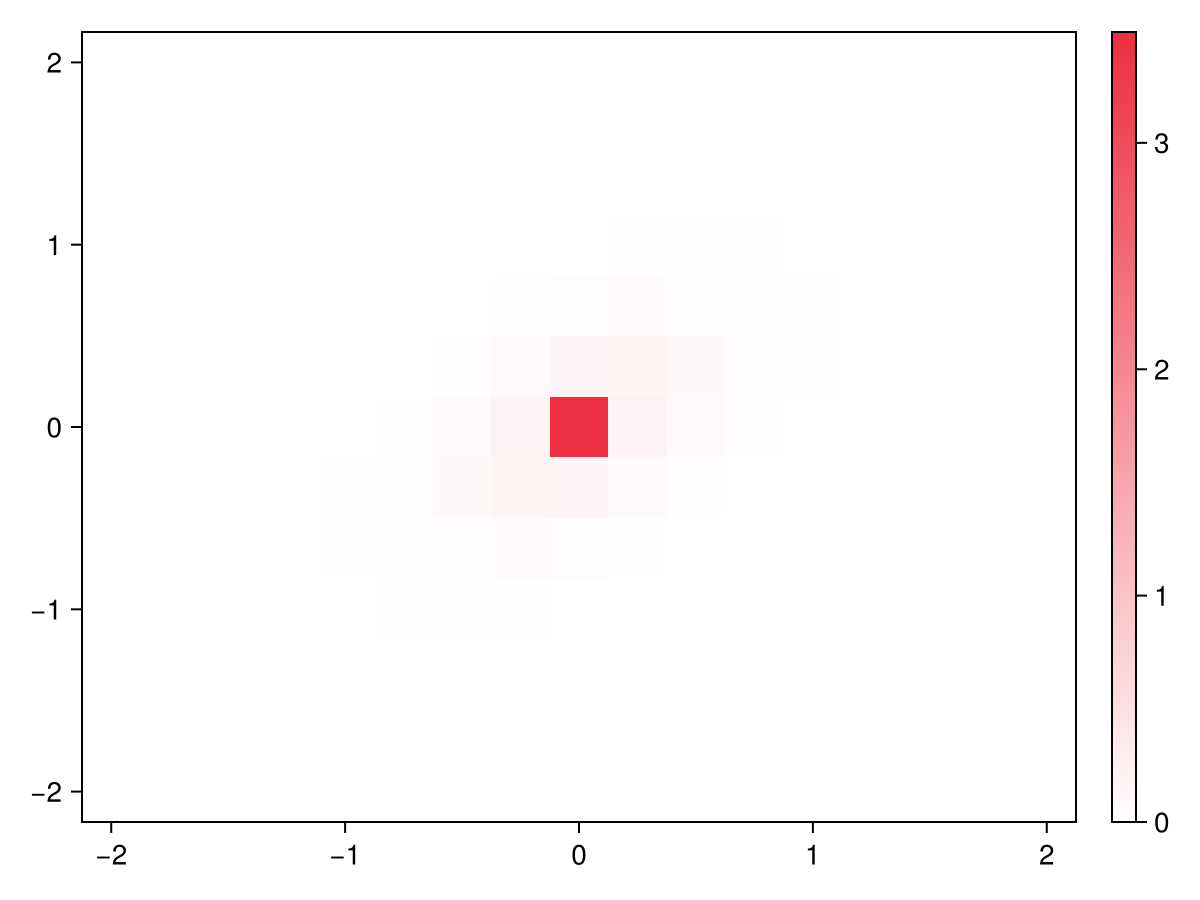

CairoMakie.Screen{IMAGE}


In [42]:
let structure_factor = str_fac66, layer = (1,2)
    fig = Figure();
    ax = Axis(fig[1,1])
    hm = heatmap!(ax, (-2Gk[1]:2Gk[1])./Gk[1], (-2Gk[2]:2Gk[2])./Gk[2], 
        real.(structure_factor[:,:,layer...]);
        colorrange = (0.0, maximum(real.(structure_factor[:,:,layer...]))),
        colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
    )
    Colorbar(fig[1, 2], hm)
    display(fig)
end

Calculate many-body Chern number

In [44]:
# twist angle path for the Wilson loop integral
N_shift = 10  # number of shifts along each edge
path = Tuple{Float64, Float64}[(0.0, 0.0)]
push!(path, (1/N_shift, 0.0))
push!(path, (1/N_shift, 1/N_shift))
push!(path, (0.0, 1/N_shift))
push!(path, (0.0, 0.0))
path

5-element Vector{Tuple{Float64, Float64}}:
 (0.0, 0.0)
 (0.1, 0.0)
 (0.1, 0.1)
 (0.0, 0.1)
 (0.0, 0.0)

In [46]:
sn = 7                     # subspace number
nstates = 1                # number of degenerating states

psi_before = vectors[sn][1:nstates]
ED_connection_gaugefixing!(psi_before)  # fix global phase

WilsonLoopIntegral= Vector{Float64}(undef, 4)
for i in eachindex(WilsonLoopIntegral)

    println("path point #$i \t $(path[i+1])")

    # One-body terms do not change when k are shifted
    scat2 = ED_sortedScatterList_twobody(para_conserve; kshift = path[i+1]);
    psi_after = EDsolve(subspaces[sn], scat2, scat_list1_conserve; N = 6,
        showtime = false,
    )[2][1:nstates]
    ED_connection_gaugefixing!(psi_after)  # fix global phase

    WilsonLoopIntegral[i] = ED_connection_step( 
        psi_after, psi_before, path[i+1], path[i], para_conserve;
        wavefunction_tol = 1e-8, print_amp = true,
        amp_warn_tol = 0.7, amp_warn = true
    )

    psi_before .= psi_after
end
ManyBodyChernNumber = sum(WilsonLoopIntegral) / (2π) * N_shift^2


path point #1 	 (0.1, 0.0)
Inner product: amp = 0.9999999999999439, phase = -0.15707963267907163
path point #2 	 (0.1, 0.1)
Inner product: amp = 0.9999999999999805, phase = 0.3979350694542598
path point #3 	 (0.0, 0.1)
Inner product: amp = 0.9999999999999853, phase = 0.18849555921596506
path point #4 	 (0.0, 0.0)
Inner product: amp = 1.0000000000000129, phase = -0.36651914291904397


1.0000000000049878